# MAC0318 - Arquiteturas sensorimotoras - Notebook 2

*Pré-requisitos*: 
- **Software**: Para rodar este notebook corretamente, você deve ter o Python na versão 3.9 ou mais recente e as bibliotecas NumPy e OpenCV. Antes de começar, assegure-se de que essas condições são satisfeitas.
- **Conhecimento**: Esta atividade assume familiaridade com o uso de notebooks Jupyter, a manipulação de matrizes usando a bilbioteca NumPy e a representação de imagens digitais coloridas em matrizes. Recomendamos seguir algum tutorial da internet antes de realizar essa atividade, se esse não for o seu caso.
- **Compreensão** do filtro de segmentação por cor, realizado no [notebook anterior](ArquiteturasSensorimotoras01.ipynb).

<span style="color:blue">Se você está rodando o notebook em sala de aula, você deve ativar o ambiente `duckievillage` antes de abrir o jupyter notebook e escolher o kernel `duckievillage`, para que os requerimentos sejam satisfeitos.</red>

## Veículo de Braitenberg

Nessa atividade você vai implementar um agente com arquiquetura sensorimotora seguindo a abordagem dos veículos de Braitenberg e assumindo que as fontes atratoras são patos, como na figura abaixo.

<figure>
  <div style="text-align: center">
  <img src="img/muitospatos.jpeg" alt="Muitos patos!" width="300">
  </div>
</figure>

Seu robô deve adotar o comportamento "enamorado" (_lover_):

> O veículo se aproxima da fonte com velocidade inversamente proporcional à distância, 
> evitando colisão com a fonte (ou seja, parando quando próximo).

Isso é feito usando a conexão sensorimotora exibida na figura abaixo:

<figure>
  <div style="text-align: center">
  <img src="img/lover.png" alt="Comportamento enamorado" width="200">
  </div>
</figure>

## Implementando os sensores de fonte de luz a partir da câmera


O sensor principal (e o único que usaremos nessa atividade) do robô duckiebot é a câmera digital frontal.

<figure>
  <div style="text-align: center">
  <img src="img/duckiebot.jpg" alt="Duckiebot" width="300">
  </div>
</figure>

Uma câmera digital é apenas uma coleção de sensores de luz organizados matricialmente.
Dada a forma matricial da imagem, vamos representar as conexões entre sensores e atuadores também como uma matriz de pesos +1 ou -1, 
indicando uma relação (conexão) *estimulante* ou *inibitória*, respectivamente.
Ademais, vamos preprocessar a imagem usando o filtro de segmentação de cores para identificar apenas a presença da cor amarela na imagem,
que será nossa fonte de estímulo.

## Sensor de patos

Mais especificamente, vamos usar obter uma matriz $`M\in\{0,1\}^{m\times n}`$ representando uma 
máscara da imagem capturada pela câmera tal que
$$
M_{ij}=\begin{cases}
  1&\text{ se o pixel }(i,j)\text{ é da cor dos patos,}\\
  0&\text{ caso contrário.}
\end{cases}
$$
Os valores $`m`$ e $`n`$ definem a largura e altura das imagens capturadas pela câmera do robô.

In [1]:
# Vamos primeiro carregar os módulo necessários
# para mostrar imagens no notebook:
%matplotlib inline 
from pylab import imshow
from matplotlib import pyplot as plt
# para maninpulação de matrizes (numpy):
import numpy as np
from numpy import uint8
# e para manipulação de imagens (opencv):
import cv2

In [2]:
# Intervalo para pontos amarelados (H em [5,30]) 
lower_hsv = np.array([5, 100, 100])    
upper_hsv = np.array([30, 255, 255])
# Imagem de exemplo
image = cv2.imread('img/pato1.jpeg') # devolve vetor multidimensional do numpy 
image = image[:,:,::-1] # Transforma canais BGR em RGB

# Construir máscara dos pontos no hiperretângulo do espaço HSV especificado
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv, lower_hsv, upper_hsv)//255;

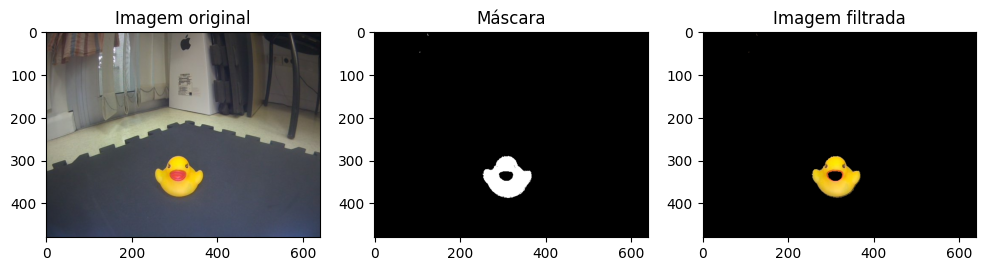

In [3]:
# Aplicar máscara na imagem (representada em RGB)
masked = cv2.bitwise_and(image[:,:,:3], image[:,:,:3], mask=mask)
f, ax = plt.subplots(1,3, figsize=(12,5))
ax[0].imshow(image);
ax[0].set_title('Imagem original');
ax[1].imshow(mask, cmap='gray');
ax[1].set_title('Máscara');
ax[2].imshow(masked[:,:,:3]);
ax[2].set_title('Imagem filtrada');

## Conexões com os motores

Para implementar o comportamento de um veículo de Braitenberg, precisamos especificar as conexões entre sensores (pixels da máscara da imagem) e atuadores (sinais para os motores esquerdo e direito).
Faremos isso definindo as matrizes de pesos de conexão $`L\in\mathbb{R}^{m \times n}`$ e $`R\in\mathbb{R}^{m \times n}`$.
O elemento $`L_{i,j}`$, por exemplo, especifica o tipo de conexão entre o sensor relativo ao pixel em $`(i,j)`$ e o motor esquerdo.
Esse elemento será +1 para uma conexão estimulante, -1 para uma conexão inibitória e 0 para ausente ("fio desconectado").

O sinal enviado a cada motor é obtido pela média de todas as conexões, usando uma relação linear.
Dessa forma, enviamos para o motor esquerdo:
$$
p_l = c + g \cdot \rho\left(\sum_{i=1}^n\sum_{j=1}^m L_{ij}\cdot M_{ij} \right) ,
$$
E para o motor direito:
$$
p_r = c + g \cdot \rho\left(\sum_{i=1}^n\sum_{j=1}^m R_{ij}\cdot M_{ij} \right) .
$$

No protocolo implementado, os valores $`p_l`$ e $`p_r`$ determinam a tensão elétrica enviada aos motores e devem estar no intervalo $`[-1,1]`$, com valores positivos movendo a roda em um sentido e valores negativos na sentido contrário. A constante $`c`$ faz com que o robô se mova na ausência de estímulo e o ganho $`g`$ determina a velocidade em relação ao estímulo médio dado pelo produto ponto-a-ponto das matrizes de conexão e da máscara da imagem. A função $`\rho`$ é uma tranformação linear que mapeia a soma dos valores de ativação para o intervalo $`[0,1]`$, como será explicado mais adiante. 

Note que diferentes comportamentos podem ser obtidos alterando apenas as matrizes de conexão.

In [4]:
# Vamos criar matrizes L e R de dimensão iguais as da imagem da câmera
L = np.zeros(shape=(image.shape[0],image.shape[1]), dtype="float32")
R = np.zeros(shape=(image.shape[0],image.shape[1]), dtype="float32")

In [5]:
# Vamos definir conexões inibitórias ligando a parte esquerda da imagem ao motor esquerdo:
L[:, :image.shape[1]//2] = -1   # -1 'inibe' ação, +1 'estimula' e 0 ignora
# e a parte direita da imagem ao motor direito:
R[:, image.shape[1]//2:] = -1

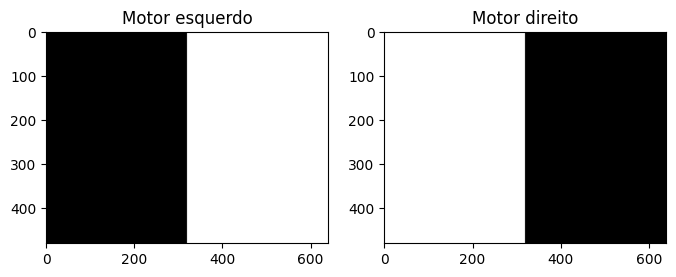

In [6]:
# Vamos visualizar as matrizes de conexões como imagens
f, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].imshow((L-L.min())/(L.max()-L.min()), cmap='gray'); # precisamos transformar matriz para [0,1] para exibí-la como imagem
ax[0].set_title('Motor esquerdo');
ax[1].imshow((R-R.min())/(R.max()-R.min()), cmap='gray');
ax[1].set_title('Motor direito');

Vamos calcular os estímulos médios:
$$`
L_\text{sum} = \sum_{i=1}^n\sum_{j=1}^m L_{ij}\cdot M_{ij}
`$$
$$`
R_\text{sum} = \sum_{i=1}^n\sum_{j=1}^m R_{ij}\cdot M_{ij}
`$$

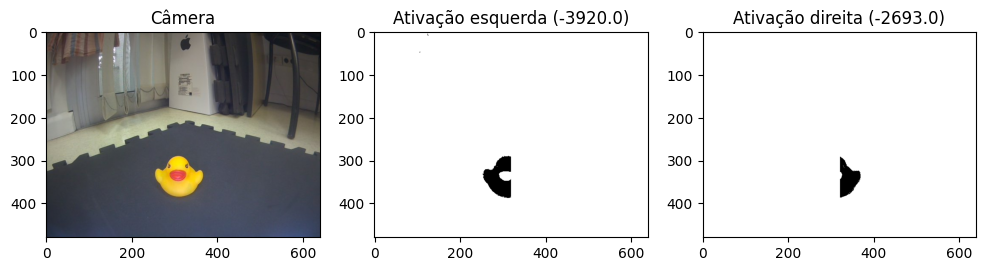

In [7]:
Lsum = np.sum(L * mask)
Rsum = np.sum(R * mask)
f, ax = plt.subplots(1,3, figsize=(12,5))
ax[0].imshow(image); 
ax[0].set_title('Câmera');
ax[1].imshow(L * mask, cmap='gray'); # precisamos transformar matriz para [0,1] para exibí-la como imagem
ax[1].set_title(f'Ativação esquerda ({Lsum})');
ax[2].imshow(R * mask, cmap='gray');
ax[2].set_title(f'Ativação direita ({Rsum})');

Note nos títulos das figuras acima como os valores de $L_\text{sum}$ e $R_\text{sum}$ possuem magnitutes grandes. Para facilitar a escolha das constantes $`c`$ e $`g`$, prevenir erros numéricos e garantir que os sinais enviados aos motores estejam no intervalo $`[-1,1]`$, vamos mapear tais valores para o intervalo $`[0,1]`$ de forma que o valor seja proporcional a proporção de pontos amarelos na imagem.
A função abaixo implementa a função $`\rho`$ na definição das equações de controle do veículo, a partir de parâmetros `lim_inf`, que representa o menor valor esperado da soma, e `lim_sup`, que representa o maior valor esperado. 

In [8]:
def rescale(x: float, lim_inf, lim_sup):
    ''' Redimensionsa valor de ativação x para intervalo [0, 1]. 
    Nota: esta função difere da função no arquivo agent.py.
    '''
    return (lim_sup - x) / (lim_sup - lim_inf)

In [9]:
# Vamos usar como limite inferior -1/4 da área da imagem e como limite inferior 0.
# Melhores valores podem ser encontrados analisando as imagens obtidas pelo robô
limit = image.shape[0] * image.shape[1]/4
rhoL = rescale(np.sum(L * mask), -limit, 0)
rhoR = rescale(np.sum(R * mask), -limit, 0)
# Valores médios normalizados
print(f'Scaled Lsum = {rhoL}')
print(f'Scaled Rsum = {rhoR}')

Scaled Lsum = 0.051041666666666666
Scaled Rsum = 0.035065104166666666


Para concluir a implementação do comportamento enamorado, você precisa definir as constantes `const` e `gain` adequadamente.
A constante `const` define a velocidade do robô na ausência de estímulo, ou seja, quando os valores redimensionados
Ela é portanto dependente da interação do robô com o piso. 

Já a constante `gain` define a redução da velocidade em função do aumento do estímulo. Uma boa heurística é considerar o caso em que gostaríamos de ter o robô parado.
Modifique os valores dessas constantes abaixo, para que o robô envie valores próximo a zero (ou levemente negativos) quando observa uma imagem de um pato muito próximo, mas valores razoavelmenten altos quando o pato está distante.

In [10]:
# Vamos definir algumas funções auxiliares primeiro
def preprocess(image: np.ndarray) -> np.ndarray:
        'Devolve máscara de filtro de segmentação por cores'
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv, lower_hsv, upper_hsv)//255
        return mask

def show_controller(image, const, gain):
    P = preprocess(image)
    rhoL = rescale(np.sum(P*L), -limit, 0)
    rhoR = rescale(np.sum(P*R), -limit, 0)
    pwm_left = const + gain*rhoL
    pwm_right = const + gain*rhoR
    f, ax = plt.subplots(1,3, figsize=(10,3))
    ax[0].imshow(image); 
    ax[0].set_title('Câmera');
    ax[1].imshow(L * P, cmap='gray'); # precisamos transformar matriz para [0,1] para exibí-la como imagem
    ax[1].set_title(f'Motor esquerdo ({pwm_left:.4f})');
    ax[2].imshow(R * P, cmap='gray');
    ax[2].set_title(f'Motor direito ({pwm_right:.4f})');    

## 💡 Exercício

Modifique as constantes `const` e `gain` abaixo para que os sinais enviados sejam < 0 na primeira imagem e > 0.3 na segunda imagem (mas ambos em [-1,1]).
Depois, avalie o resultado nas imagens seguintes e ajusete novamente as constantes até que o comportamento fique satisfatório.

*Lembre-se*: queremos que a ativação descresça com o aumento de estímulo.

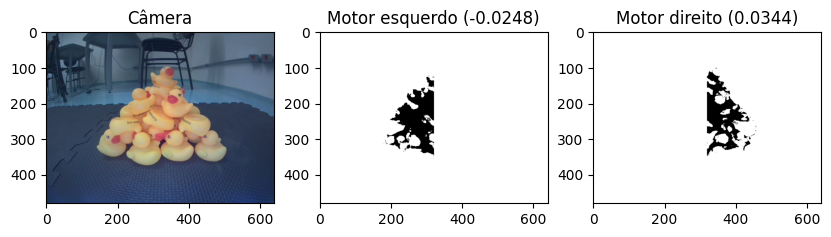

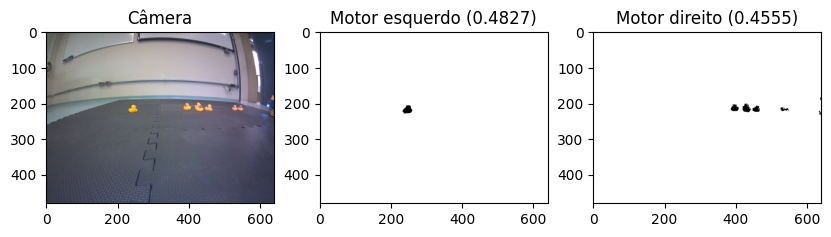

In [17]:
# Modifique as constantes abaixo
const, gain = .5, -3

image_perto = cv2.imread('img/piramide_perto.jpeg')
image_perto = image_perto[:,:,::-1] # Transforma canais BGR em RGB
show_controller(image_perto, const, gain)
image_longe = cv2.imread('img/patolonge.jpeg')
image_longe = image_longe[:,:,::-1] # Transforma canais BGR em RGB
show_controller(image_longe, const, gain)

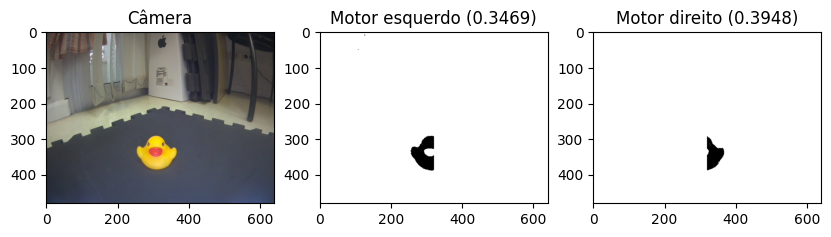

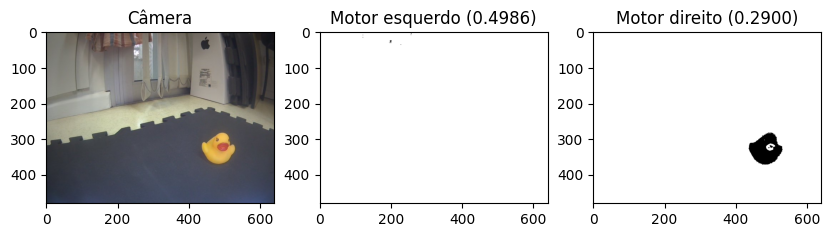

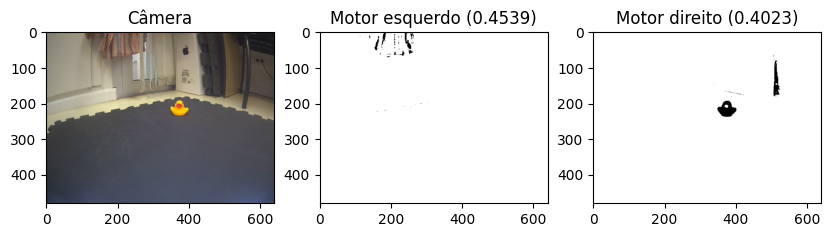

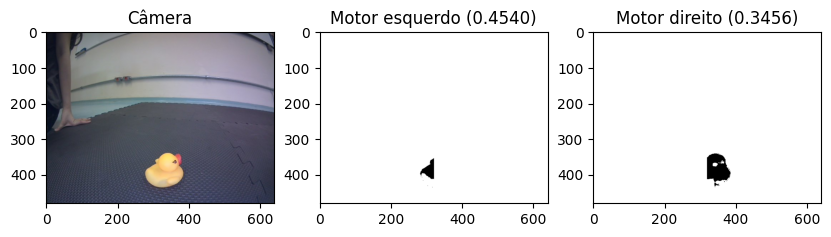

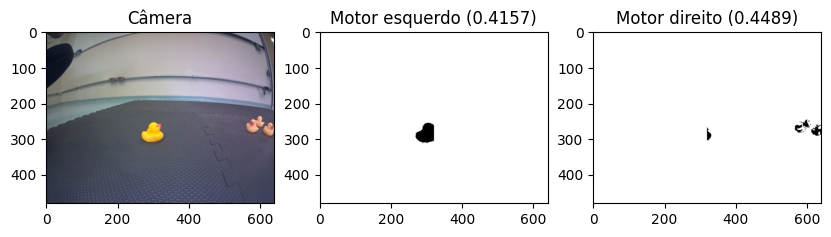

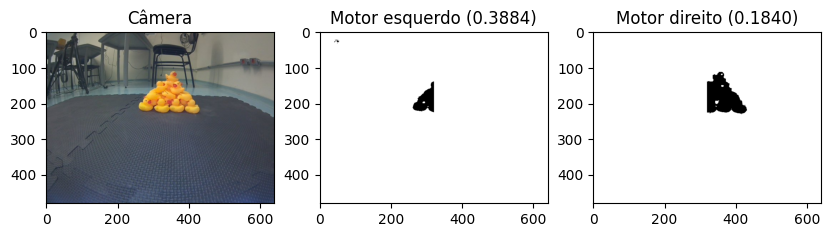

In [18]:
# Agora observe o comportamento em outras imagens/condições
dirname = 'img'
filenames = ['pato1.jpeg', 'pato2.jpeg', 'pato3.jpeg', 'patoperto.jpeg', 'patomedio.jpeg', 'piramide_longe.jpeg']
for filename in filenames:
    image = cv2.imread(f'{dirname}/{filename}') 
    image = image[:,:,::-1] # Transforma canais BGR em RGB
    show_controller(image, const, gain)

Modifique os valores de `const` e `gain` para atingir o comportamento esperado do robô nas situações das imagens acima.